In [43]:
# importing standard packages
import pandas as pd
import numpy as np 
from scipy import stats 

# importing the plot funnctions
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline 

# preprocessing/ model selection 
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score

# importing the classifiers 
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

# importing the metrics 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, classification_report,f1_score
from sklearn.metrics import roc_curve

# oversampling techniques 
from imblearn.over_sampling import SMOTE

# importing model saving package 
from joblib import dump, load

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline, make_pipeline

# Functions

In [49]:
def draw_conf_mat(mat):
    
    """
    Draw confusion matrix
    
    Parameters:
    ------------------
    mat:                ndarray of shape (n_classes, n_classes) 
                        confusion matrix

    """
    
    import matplotlib.pyplot as plt 
    import seaborn as sns
    
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(mat, annot=True, fmt="d",
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    ax.set_ylim([0,2])
    ax.invert_yaxis()
    plt.show()
    
    return ax

In [3]:
# grab the stored data frames
%store -r X_wids
%store -r y_wids

In [7]:
X_wids = X_wids.drop(columns= ['hospital_admit_source_Observation'])

In [8]:
X_wids.shape, y_wids.shape

((91713, 597), (91713, 1))

## Train Test Split without Correction of Imbalanced Data

In [9]:
# Split train-test dataset 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_wids, y_wids, test_size = 0.2, random_state = 31, stratify = y_wids)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(73370, 597) (18343, 597) (73370, 1) (18343, 1)


# RandomSearch

In [11]:
# Load the pipeline of LGB_U
LGB_U_pipeline = load('LGB_U.joblib')

In [31]:
# Set parameters we want to search
lgb_params = {'num_leaves': [20,31, 50, 60, 90],
              'learning_rate': [.01,.05,1.0],
            'n_estimators': [100,150,200,250],
            'min_data_in_leaf':[50,100,200],
             'max_depth': [7, 10, -1]}

In [32]:
# Change lgb_params to pipeline format
new_params = {'lgbmclassifier__' + key: lgb_params[key] for key in lgb_params}

In [33]:
rnd_search = RandomizedSearchCV(LGB_U_pipeline, param_distributions=new_params, cv=4, n_iter=11, scoring='recall',
                        return_train_score=True)
rnd_search.fit(X_train.values, y_train.values.ravel())

/Users/Jenny/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/Jenny/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/Jenny/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/Jenny/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  war

/Users/Jenny/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/Jenny/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/Jenny/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/Jenny/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  war

RandomizedSearchCV(cv=4, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('randomundersampler',
                                              RandomUnderSampler(random_state=42,
                                                                 ratio=None,
                                                                 replacement=False,
                                                                 return_indices=False,
                                                                 sampling_strategy=1)),
                                             ('lgbmclassifier',
                                              LGBMClassifier(booster='gbtree',
                                                             boosting_type='gbdt',
                                                             class_weight=None,
                                                             colsample_bytree=1.0,
                                

In [34]:
rnd_search.best_params_

{'lgbmclassifier__num_leaves': 90,
 'lgbmclassifier__n_estimators': 250,
 'lgbmclassifier__min_data_in_leaf': 50,
 'lgbmclassifier__max_depth': 10,
 'lgbmclassifier__learning_rate': 0.05}

# Evaluate

In [46]:
# Build the model with our best parameters
lgb_best = LGBMClassifier(booster ='gbtree', n_estimators = 250, learning_rate = .05, 
                          max_depth = 10, num_leaves=90, min_data_in_leaf=50, objective ='binary')

# Make undersampling
rus = RandomUnderSampler(sampling_strategy = 1, random_state=42)
lgb_rus_pipeline = make_pipeline(rus,lgb_best)

In [47]:
result_matrix = pd.DataFrame(columns = ['model', 'precision_test', 'recall_test', 'FPR_test', 'AUROC_test',
                                     'f1_test', 'f1_train', 'f1_CV'])
# fit model
lgb_rus_pipeline.fit(X_train.values, y_train.values.ravel())

# prediction of y based on X_test
y_predict = lgb_rus_pipeline.predict(X_test.values)
    
# prediction of y probability based on X_test
y_proba = lgb_rus_pipeline.predict_proba(X_test.values)[:,1]

# prediction of y based on X_train
y_train_predict = lgb_rus_pipeline.predict(X_train.values)

cmat = confusion_matrix(y_test.values.ravel(), y_predict)
# tp, fn, fp, tn
tp = cmat[1,1]
fn = cmat[1,0]
fp = cmat[0,1]
tn = cmat[0,0]

#precision score on test
p_score_test = precision_score(y_test.values.ravel(), y_predict)

#recall score on test
r_score_test = tp/(tp+fn) 

#FPR score on test
fpr_test = fp/(fp+tn)

#AUROC score on test
auroc_test = roc_auc_score(y_test.values.ravel(), y_proba)

#f1 score on test
f1_test = f1_score(y_test.values.ravel(), y_predict)

#f1 score on train
f1_train = f1_score(y_train.values.ravel(), y_train_predict)

#f1 score on cross validation 
k_fold = 4
f1_cv = cross_val_score(lgb_rus_pipeline, X_train, y_train.values.ravel(), cv=k_fold, scoring = 'f1')
recall_cv = cross_val_score(lgb_rus_pipeline, X_train.values, y_train.values.ravel(), 
                            cv=k_fold, scoring = 'recall')
print(f"Cross Validation is on {k_fold} folds.")

# append to matrix
df2 = pd.DataFrame([['LGB_U_tuned',p_score_test,r_score_test, fpr_test, auroc_test, f1_test, f1_train, f1_cv, recall_cv]], 
                       columns=['model', 'precision_test', 'recall_test', 'FPR_test', 'AUROC_test',
                                     'f1_test', 'f1_train', 'f1_CV', 'recall_CV'])
    
result_matrix = pd.concat([df2, result_matrix])

/Users/Jenny/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/Jenny/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/Jenny/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/Jenny/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  war

Cross Validation is on 4 folds.


In [50]:
result_matrix.explode('f1_CV')

,model,precision_test,recall_test,FPR_test,AUROC_test,f1_test,f1_train,f1_CV,recall_CV
0,LGB_U_tuned,0.290438,0.821226,0.189499,0.898039,0.429114,0.512608,0.415793,"[0.8016424510423247, 0.8294377763739734, 0.814..."
0,LGB_U_tuned,0.290438,0.821226,0.189499,0.898039,0.429114,0.512608,0.43891,"[0.8016424510423247, 0.8294377763739734, 0.814..."
0,LGB_U_tuned,0.290438,0.821226,0.189499,0.898039,0.429114,0.512608,0.421586,"[0.8016424510423247, 0.8294377763739734, 0.814..."
0,LGB_U_tuned,0.290438,0.821226,0.189499,0.898039,0.429114,0.512608,0.418756,"[0.8016424510423247, 0.8294377763739734, 0.814..."


In [51]:
# We are fine with this result. CV score and train score are different by 10%. We will accept this for now. 

# save model
dump(lgb_rus_pipeline, 'LGB_u_best.joblib')

['LGB_u_best.joblib']

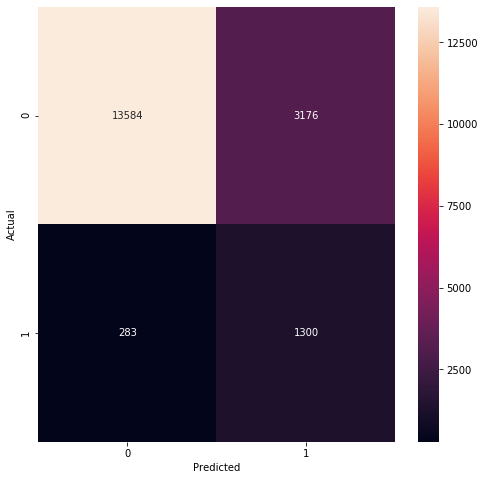

In [52]:
# Draw confusion matrix
draw_conf_mat(cmat)